In [1]:
import os
import json
import pandas as pd
from typing import Dict, Any
from urllib.request import urlretrieve
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import folium
from shapely.geometry import Point
from shapely import wkt
import openrouteservice
import polars as pl
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge


## Preforcast Preprocessing

In [2]:
df = pd.read_csv('../data/curated/forcast_dataset.csv')

In [3]:
df.sort_values(by=['year','month'], inplace=True)

In [4]:
df.value_counts(['year'], ascending=True)


year
2018        60
2019        97
2020       184
2021       448
2022       660
2023       955
2024     11977
2017    149572
2016    155236
2015    165369
Name: count, dtype: int64

In [5]:
sum(df.isnull().sum())

0

In [6]:
df.columns
df.drop(['longitude','latitude','Year'], axis=1, inplace=True)

In [7]:
df.columns

Index(['suburb', 'rent', 'num_bedrooms', 'num_bathrooms', 'parking',
       'distance_to_cbd', 'nearst_train_station_dist', 'year', 'month',
       'num_primary', 'num_secondary_public', 'num_secondary_private',
       'num_secondary_catholic', 'num_edu_centre', 'v_high_vcaa', 'high_vcaa',
       'good_vcaa', 'property_type_apartment / unit / flat',
       'property_type_duplex', 'property_type_duplex-semi-detached',
       'property_type_house', 'property_type_retirement living',
       'property_type_serviced apartment', 'property_type_studio',
       'property_type_townhouse', 'property_type_villa', 'lga',
       'Rate per 100,000 population', 'lga_population'],
      dtype='object')

In [8]:
suburbs  = df['suburb'].unique()



## Quick feature aggregation 

In [9]:
df['avg_distance_to_cbd'] = df.groupby('suburb')['distance_to_cbd'].transform('mean')
df['avg_rent_by_suburb'] = df.groupby('suburb')['rent'].transform('mean')
df['median_rent_by_suburb'] = df.groupby('suburb')['rent'].transform('median')

df.drop('distance_to_cbd', inplace=True, axis=1)

In [10]:
df.columns

Index(['suburb', 'rent', 'num_bedrooms', 'num_bathrooms', 'parking',
       'nearst_train_station_dist', 'year', 'month', 'num_primary',
       'num_secondary_public', 'num_secondary_private',
       'num_secondary_catholic', 'num_edu_centre', 'v_high_vcaa', 'high_vcaa',
       'good_vcaa', 'property_type_apartment / unit / flat',
       'property_type_duplex', 'property_type_duplex-semi-detached',
       'property_type_house', 'property_type_retirement living',
       'property_type_serviced apartment', 'property_type_studio',
       'property_type_townhouse', 'property_type_villa', 'lga',
       'Rate per 100,000 population', 'lga_population', 'avg_distance_to_cbd',
       'avg_rent_by_suburb', 'median_rent_by_suburb'],
      dtype='object')

In [11]:
# df['bath_bed_toghether'] = df['num_bathrooms'] + df['num_bedrooms']
# df['bath_bed_int'] =  df['num_bathrooms']*df['num_bedrooms']


# df.drop(['num_bathrooms','num_bedrooms'], axis=1, inplace=True)

<Axes: xlabel='date'>

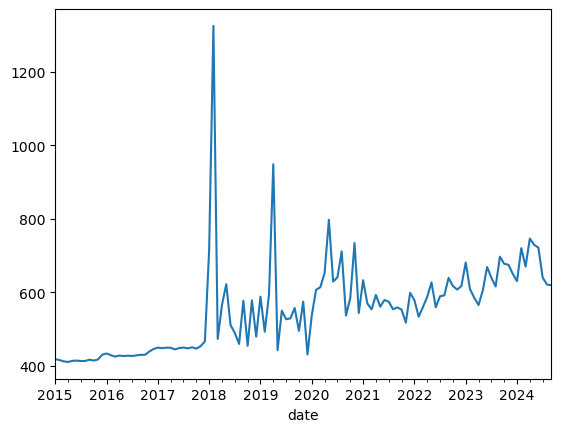

In [12]:
# draw time series plot for rent 
df_draw = df.copy()
df_draw['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df_draw.set_index('date', inplace=True)
df_draw.drop(['year', 'month'], axis=1, inplace=True)

df_draw_plot = df_draw.groupby('date')['rent'].mean()
df_draw_plot.plot()




## Aggregating the data for ARIMA forcast

In [13]:
# df_arima = df.copy()    
# df_arima['date'] = pd.to_datetime(df_arima[['year', 'month']].assign(DAY=1))
# df_arima.set_index('date', inplace=True)

In [14]:
# df_arima.drop(['year','month'], axis=1, inplace=True)

In [15]:
# df_arima_train = df_arima.loc['2015-01-01':'2019-12-01']


### Minor Preprocessing

In [16]:


df_reg = df.copy()
df_reg_sub = df_reg[['suburb']]
df_reg.drop(['suburb'], axis=1, inplace=True)
df_reg.drop(['lga'],axis=1, inplace=True)

X = df_reg.drop('rent', axis=1)
y = df_reg['rent']

X_train = X.loc[df_reg['year'] < 2022]
X_test = X.loc[df_reg['year'] >= 2022]
y_train = y.loc[df_reg['year'] < 2022]
y_test = y.loc[df_reg['year'] >= 2022]

df_reg_sub_train = df_reg_sub.loc[df_reg['year'] < 2022]
df_reg_sub_test = df_reg_sub.loc[df_reg['year'] >= 2022]

# y_test = np.log(y_test)
# y_train = np.log(y_train)


# Dummy model

In [17]:
from sklearn.dummy import DummyRegressor

dummy_model = DummyRegressor(strategy="mean") 
dummy_model.fit(X_train, y_train) 

y_dummy_pred = dummy_model.predict(X_test)

dummy_mse = mean_squared_error(y_test, y_dummy_pred)
dummy_r2 = r2_score(y_test, y_dummy_pred)

print(f'Dummy Model Mean Squared Error: {dummy_mse}')
print(f'Dummy Model R2 Score: {dummy_r2}')


Dummy Model Mean Squared Error: 111457.72255226344
Dummy Model R2 Score: -0.5498302161206887


## Training and testing linear regression per property basis

(array([2.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 3.00000e+00, 1.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00,
        1.00000e+00, 4.00000e+00, 5.00000e+00, 3.00000e+01, 2.10000e+01,
        1.00000e+01, 8.00000e+00, 3.80000e+01, 1.68000e+02, 4.49000e+02,
        1.67400e+03, 4.36600e+03, 1.11650e+04, 3.02820e+04, 6.79910e+04,
        1.20931e+05, 9.95060e+04, 5.69780e+04, 4.05980e+04, 2.12640e+04,
        1.33600e+04, 7.20900e+03, 3.54700e+03, 2.17800e+03, 1.35700e+03,
        7.98000e+02, 2.46000e+02, 2.40000e+02, 8.20000e+01, 4.00000e+01]),
 array([0.        , 0.16537464, 0.33074927, 0.49612391, 0.66149855,
        0.82687318, 0.99224782, 1.15762246, 1.32299709, 1.48837173,
        1.65374637, 1.819121  , 1.98449564, 2.14987028, 2.31524491,
        2.48061955, 2.64599419, 2.81136882, 2.97674346, 3.142118

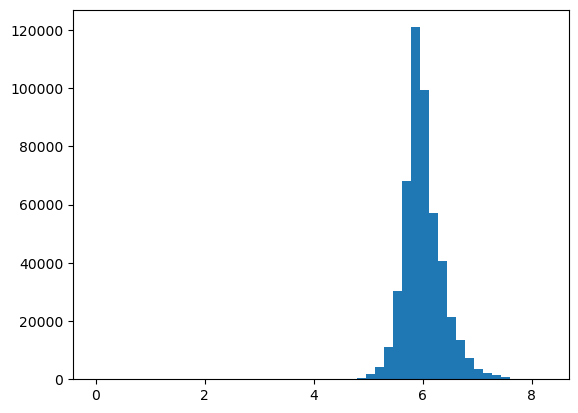

In [18]:

plt.hist(np.log(y), bins=50)

(array([1.7000e+01, 6.7000e+01, 1.1500e+02, 1.3150e+03, 5.2670e+03,
        1.1170e+04, 2.7589e+04, 4.9573e+04, 8.0456e+04, 7.2301e+04,
        5.2865e+04, 4.4359e+04, 3.3807e+04, 1.7848e+04, 2.1213e+04,
        1.3604e+04, 1.1416e+04, 9.1920e+03, 3.0390e+03, 5.4630e+03,
        3.6000e+03, 3.4770e+03, 1.9070e+03, 2.1270e+03, 1.8840e+03,
        1.8110e+03, 1.0430e+03, 3.9900e+02, 1.0460e+03, 3.8100e+02,
        1.0980e+03, 1.9300e+02, 5.2600e+02, 8.0000e+02, 3.5400e+02,
        4.3200e+02, 4.1000e+01, 1.3800e+02, 5.4700e+02, 1.0900e+02,
        5.9000e+01, 2.0900e+02, 1.3300e+02, 1.6700e+02, 1.2700e+02,
        1.1000e+01, 2.0000e+02, 7.4000e+01, 8.1000e+01, 5.9000e+01,
        1.6000e+01, 2.2600e+02, 1.0000e+01, 4.5000e+01, 5.0000e+00,
        2.1000e+01, 9.1000e+01, 2.7000e+01, 3.3000e+01, 4.0000e+00,
        9.0000e+00, 3.3000e+01, 8.0000e+00, 8.0000e+00, 1.0600e+02,
        3.0000e+00, 2.3000e+01, 7.0000e+00, 1.0000e+00, 1.2000e+01,
        1.9000e+01, 2.0000e+01, 2.0000e+00, 2.00

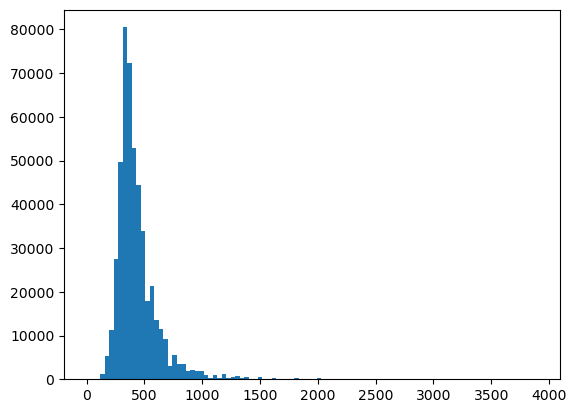

In [19]:
plt.hist((y), bins=100)

In [20]:
X_train.columns
# X_train['lga']

Index(['num_bedrooms', 'num_bathrooms', 'parking', 'nearst_train_station_dist',
       'year', 'month', 'num_primary', 'num_secondary_public',
       'num_secondary_private', 'num_secondary_catholic', 'num_edu_centre',
       'v_high_vcaa', 'high_vcaa', 'good_vcaa',
       'property_type_apartment / unit / flat', 'property_type_duplex',
       'property_type_duplex-semi-detached', 'property_type_house',
       'property_type_retirement living', 'property_type_serviced apartment',
       'property_type_studio', 'property_type_townhouse',
       'property_type_villa', 'Rate per 100,000 population', 'lga_population',
       'avg_distance_to_cbd', 'avg_rent_by_suburb', 'median_rent_by_suburb'],
      dtype='object')

Mean Squared Error: 42298.430066434616
R2 Score: 0.4118363132649804


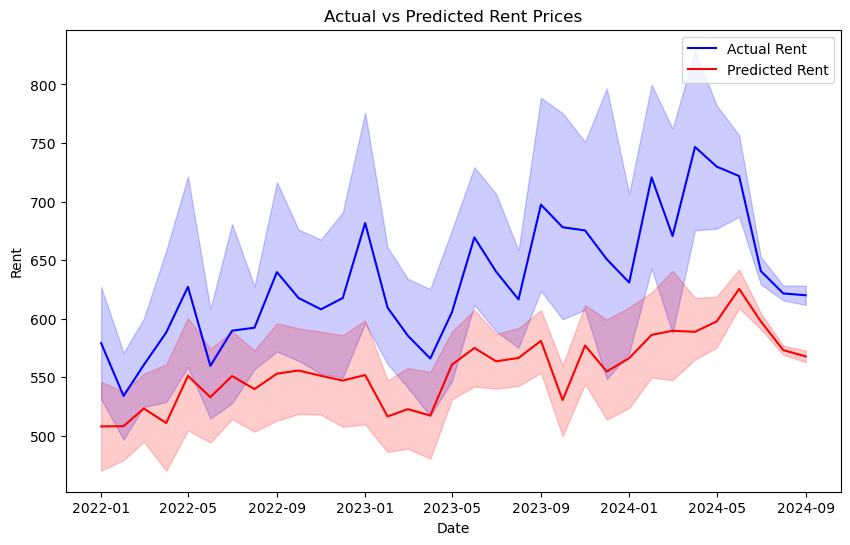

In [21]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred = lin_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)



print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

plt.figure(figsize=(10, 6))
sns.lineplot(x=pd.to_datetime(X_test[['year', 'month']].assign(day=1)).values, y=y_test, label='Actual Rent', color='blue')
sns.lineplot(x=pd.to_datetime(X_test[['year', 'month']].assign(day=1)).values, y=y_pred, label='Predicted Rent', color='red')
plt.title('Actual vs Predicted Rent Prices')
plt.xlabel('Date')
plt.ylabel('Rent')
plt.legend()
plt.show()




In [22]:

rent1 = y_test.rename('rent1')

result = pd.concat([rent1.reset_index(drop=True), pd.Series(y_pred, name='predicted_rent').reset_index(drop=True), X_test.reset_index(drop=True),y_test.reset_index(drop=True),df_reg_sub_test.reset_index(drop=True)], axis=1)
print(result.head())

   rent1  predicted_rent  num_bedrooms  num_bathrooms  parking  \
0  510.0      380.287991           3.0            1.0      2.0   
1  460.0      378.648745           2.0            1.0      1.0   
2  720.0      598.222488           3.0            2.0      4.0   
3  610.0      533.360992           4.0            2.0      2.0   
4  550.0      537.429479           2.0            1.0      0.0   

   nearst_train_station_dist  year  month  num_primary  num_secondary_public  \
0                   0.323394  2022      1            8                     3   
1                   0.308021  2022      1            7                     2   
2                   0.302302  2022      1            5                     1   
3                   4.479085  2022      1            6                     2   
4                   1.582158  2022      1            4                     0   

   ...  property_type_studio  property_type_townhouse  property_type_villa  \
0  ...                 False                

In [23]:
result[['rent','rent1']]

,rent,rent1
0,510.0,510.0
1,460.0,460.0
2,720.0,720.0
3,610.0,610.0
4,550.0,550.0
...,...,...
13587,620.0,620.0
13588,580.0,580.0
13589,1095.0,1095.0
13590,720.0,720.0


In [24]:
result[result['suburb'] == 'abbotsford']

,rent1,predicted_rent,num_bedrooms,num_bathrooms,parking,nearst_train_station_dist,year,month,num_primary,num_secondary_public,...,property_type_studio,property_type_townhouse,property_type_villa,"Rate per 100,000 population",lga_population,avg_distance_to_cbd,avg_rent_by_suburb,median_rent_by_suburb,rent,suburb
1411,915.0,721.912106,3.0,2.0,1.0,0.299541,2023,9,2,0,...,False,True,False,12913.553895,97448.000000,4.026649,505.134401,480.0,915.0,abbotsford
1664,780.0,706.024897,3.0,2.0,2.0,1.383839,2024,1,2,0,...,False,False,False,13543.603693,97727.776726,4.026649,505.134401,480.0,780.0,abbotsford
1850,1800.0,862.510886,4.0,3.0,2.0,0.741504,2024,3,2,0,...,False,False,False,13543.603693,97727.776726,4.026649,505.134401,480.0,1800.0,abbotsford
1934,900.0,639.713744,2.0,2.0,1.0,1.356315,2024,4,2,0,...,False,False,False,13543.603693,97727.776726,4.026649,505.134401,480.0,900.0,abbotsford
2152,800.0,640.654015,2.0,2.0,1.0,1.495632,2024,5,2,0,...,False,False,False,13543.603693,97727.776726,4.026649,505.134401,480.0,800.0,abbotsford
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12864,430.0,498.668313,1.0,1.0,1.0,0.581582,2024,9,2,0,...,False,False,False,13543.603693,97727.776726,4.026649,505.134401,480.0,430.0,abbotsford
12945,480.0,489.644837,1.0,1.0,0.0,1.356315,2024,9,2,0,...,False,False,False,13543.603693,97727.776726,4.026649,505.134401,480.0,480.0,abbotsford
13075,580.0,557.551548,2.0,1.0,1.0,1.263224,2024,9,2,0,...,False,False,False,13543.603693,97727.776726,4.026649,505.134401,480.0,580.0,abbotsford
13124,520.0,489.961788,1.0,1.0,0.0,1.495632,2024,9,2,0,...,False,False,False,13543.603693,97727.776726,4.026649,505.134401,480.0,520.0,abbotsford


## Train and test the ridge regression model 

### evaluate the rankings for features 

Mean Squared Error: 42298.36460777131
R2 Score: 0.4118372234739095
                                       Coefficient  Absolute Coefficient
num_bathrooms                            85.066415             85.066415
property_type_studio                     83.277912             83.277912
num_bedrooms                             57.331856             57.331856
property_type_apartment / unit / flat   -43.890646             43.890646
property_type_villa                     -43.048025             43.048025
property_type_house                     -29.588380             29.588380
property_type_retirement living          27.292047             27.292047
property_type_serviced apartment         15.623580             15.623580
year                                     13.335424             13.335424
parking                                  10.786064             10.786064
num_edu_centre                           10.749870             10.749870
good_vcaa                                 9.058046       

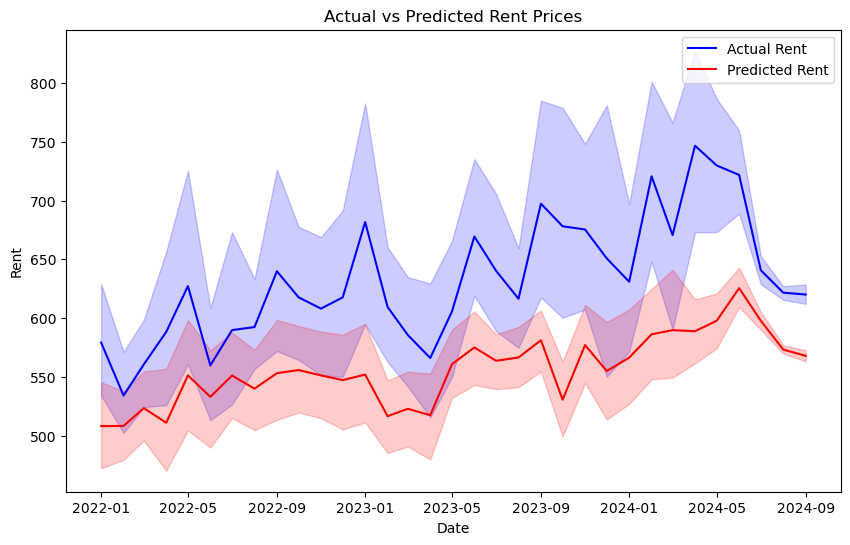

In [25]:
ridge_model = Ridge(alpha=1)
ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')


# find the most significant features
coefficients = pd.DataFrame(ridge_model.coef_, index=X_train.columns, columns=['Coefficient'])
coefficients['Absolute Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values(by='Absolute Coefficient', ascending=False)
print(coefficients)

plt.figure(figsize=(10, 6))
sns.lineplot(x=pd.to_datetime(X_test[['year', 'month']].assign(day=1)).values, y=y_test, label='Actual Rent', color='blue')
sns.lineplot(x=pd.to_datetime(X_test[['year', 'month']].assign(day=1)).values, y=y_pred, label='Predicted Rent', color='red')
plt.title('Actual vs Predicted Rent Prices')
plt.xlabel('Date')
plt.ylabel('Rent')
plt.legend()
plt.show()


## 

## Train and Test the Random forrest and find the important features

Mean Squared Error: 40942.277792042216
R2 Score: 0.4306937394207013
Feature ranking:
1. feature avg_rent_by_suburb (0.3239274450593569)
2. feature num_bathrooms (0.20240995258200054)
3. feature nearst_train_station_dist (0.15456185893414034)
4. feature num_bedrooms (0.08449784400464824)
5. feature avg_distance_to_cbd (0.05066520212657994)
6. feature month (0.04348449445491994)
7. feature lga_population (0.026600656494224686)
8. feature parking (0.022948056720078203)
9. feature median_rent_by_suburb (0.021558766024665766)
10. feature Rate per 100,000 population (0.01846732545808424)
11. feature year (0.009722197945373013)
12. feature property_type_apartment / unit / flat (0.006589069123056088)
13. feature num_primary (0.005060056202363744)
14. feature v_high_vcaa (0.004909715855473674)
15. feature property_type_house (0.004786265196479875)
16. feature property_type_townhouse (0.004034459634809445)
17. feature num_secondary_private (0.003643052891178837)
18. feature num_secondary_public 

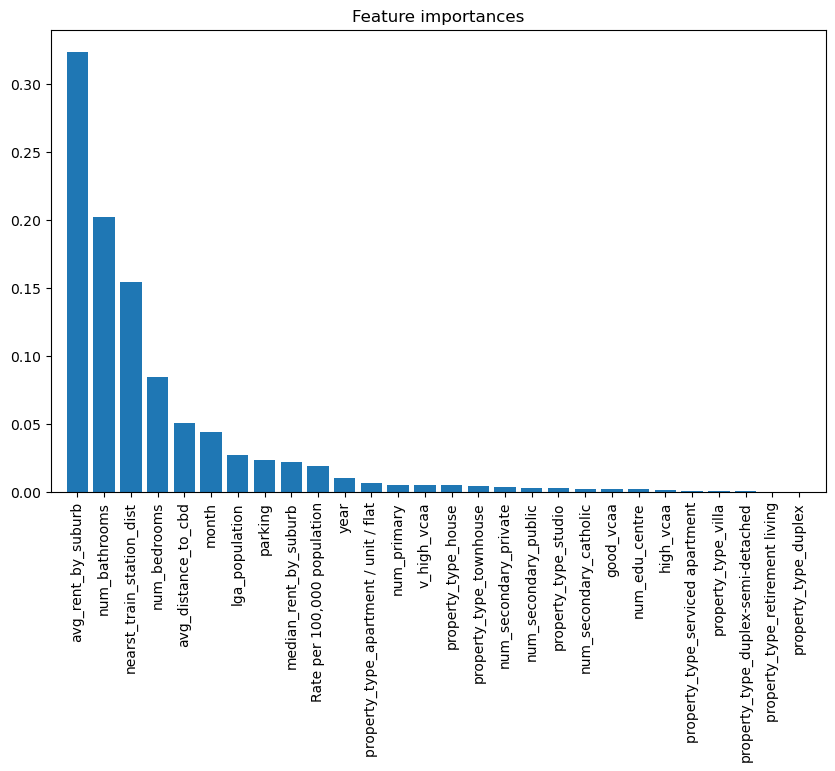

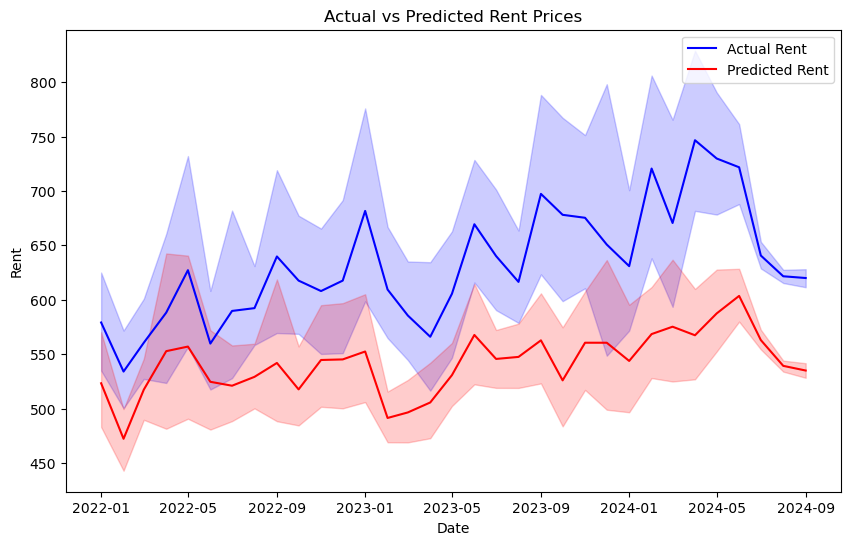

In [26]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')


# find the most significant features
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X_train.columns

print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. feature {features[indices[f]]} ({importances[indices[f]]})")

plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x=pd.to_datetime(X_test[['year', 'month']].assign(day=1)).values, y=y_test, label='Actual Rent', color='blue')
sns.lineplot(x=pd.to_datetime(X_test[['year', 'month']].assign(day=1)).values, y=y_pred, label='Predicted Rent', color='red')
plt.title('Actual vs Predicted Rent Prices')
plt.xlabel('Date')
plt.ylabel('Rent')
plt.legend()
plt.show()

## Preparing data to forcast

In [44]:
lga_pop = pd.read_csv('../data/curated/lga_pop.csv')

In [45]:


lga_pop_2025 = lga_pop[lga_pop['year'] == 2025] 
lga_pop_2025 = lga_pop_2025.drop('year', axis=1)


lga_pop_2026 = lga_pop[lga_pop['year'] == 2026]
lga_pop_2026 = lga_pop_2026.drop('year', axis=1)


lga_pop_2027 = lga_pop[lga_pop['year'] == 2027]
lga_pop_2027 = lga_pop_2027.drop('year', axis=1)

In [46]:
df.columns

Index(['rent', 'num_bedrooms', 'num_bathrooms', 'parking',
       'nearst_train_station_dist', 'year', 'month', 'num_primary',
       'num_secondary_public', 'num_secondary_private',
       'num_secondary_catholic', 'num_edu_centre', 'v_high_vcaa', 'high_vcaa',
       'good_vcaa', 'property_type_apartment / unit / flat',
       'property_type_duplex', 'property_type_duplex-semi-detached',
       'property_type_house', 'property_type_retirement living',
       'property_type_serviced apartment', 'property_type_studio',
       'property_type_townhouse', 'property_type_villa', 'lga',
       'Rate per 100,000 population', 'lga_population', 'avg_distance_to_cbd',
       'avg_rent_by_suburb', 'median_rent_by_suburb'],
      dtype='object')

In [49]:

df_forcast = df.copy()


# df_reg_sub = df_forcast['suburb']
# df.drop(['suburb'], axis=1, inplace=True)



# df_reg.drop(['lga'], axis=1, inplace=True)

X_train = df.drop('rent', axis=1)
X_train.drop(['lga'], axis=1, inplace=True)

y_train = df['rent']




df_forcast_2025 = df.copy()
df_forcast_2025['year'] = 2025

X_forcast_2025 = df_forcast_2025.drop(['rent',"lga_population"], axis=1)
X_forcast_2025 = pd.merge(X_forcast_2025, lga_pop_2025, on='lga', how='left')


X_forcast_2025.drop('lga', axis=1, inplace=True)

# gygvyb

df_forcast_2026 = df.copy()
df_forcast_2026['year'] = 2026

X_forcast_2026 = df_forcast_2026.drop(['rent',"lga_population"], axis=1)
X_forcast_2026 = pd.merge(X_forcast_2026, lga_pop_2026, on='lga', how='left')


X_forcast_2026.drop('lga', axis=1, inplace=True)

#  vyvbubu

df_forcast_2027 = df.copy()
df_forcast_2027['year'] = 2027

X_forcast_2027 = df_forcast_2027.drop(['rent',"lga_population"], axis=1)
X_forcast_2027 = pd.merge(X_forcast_2027, lga_pop_2027, on='lga', how='left')


X_forcast_2027.drop('lga', axis=1, inplace=True)

num_bedrooms                             0
num_bathrooms                            0
parking                                  0
nearst_train_station_dist                0
year                                     0
month                                    0
num_primary                              0
num_secondary_public                     0
num_secondary_private                    0
num_secondary_catholic                   0
num_edu_centre                           0
v_high_vcaa                              0
high_vcaa                                0
good_vcaa                                0
property_type_apartment / unit / flat    0
property_type_duplex                     0
property_type_duplex-semi-detached       0
property_type_house                      0
property_type_retirement living          0
property_type_serviced apartment         0
property_type_studio                     0
property_type_townhouse                  0
property_type_villa                      0
lga        

## Forcasting using Random forest